## Nonlinear Regime

In [94]:
# %% minimal bootstrap: find project root and ensure diffinst is importable
import sys, os, subprocess, importlib.util
from pathlib import Path

def find_project_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(50):
        if any((p / m).exists() for m in ("pyproject.toml", ".git", "defaults.yaml")):
            return p
        if p == p.parent:
            break
        p = p.parent
    return start.resolve()

_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    spec = importlib.util.find_spec(pkg_name)
    need = (not spec) or (not getattr(spec, "origin", None)) or (
        Path(spec.origin).resolve().parents[0] != pkg_dir.resolve()
    )
    if need:
        print(f"Installing {pkg_name} in editable mode from {pkg_dir} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(pkg_dir)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")
print("project root:", ROOT)

diffinst already installed from this repo.
project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


### initial condition

In [162]:
! python -m scripts.make_ic_eigen \
  --config experiments/unstable_baseline.yaml \
  --defaults defaults.yaml \
  --out runs/ic_k100_eigen_highamp_Nx128.npz \
  --k 100.0 \
  --amp 0.2 \
  --Nx 128 \
  --exact-fit-harm 2

[make_ic_eigen] IC written to runs/ic_k100_eigen_highamp_Nx128.npz (k=100.0, amp=0.2, Nx=128)


Loaded IC from: runs/ic_k100_eigen_highamp_Nx128.npz
Nx = 128, Lx = 0.12566370614359174, S0 = 1.0
min Σ = 0.8, max Σ = 1.2


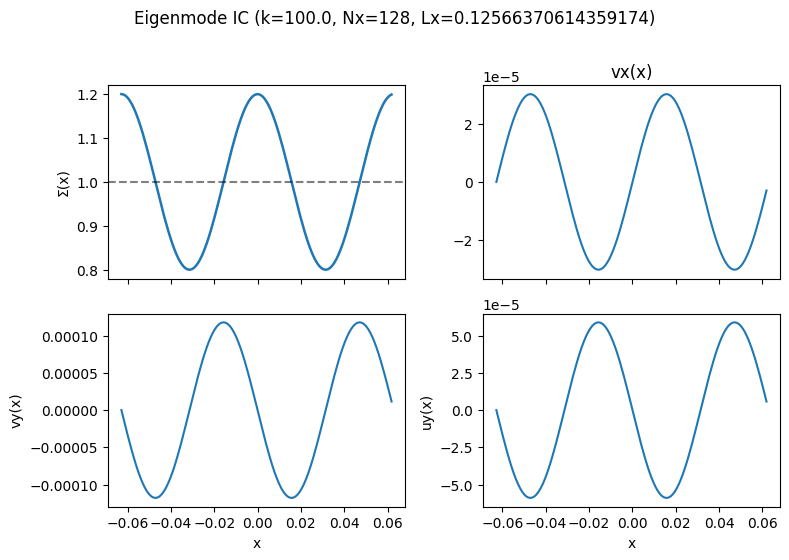

In [163]:
# %% Load and plot eigenmode IC via direct np.load (works with dict meta)
import numpy as np
import matplotlib.pyplot as plt

IC_FILE = "runs/ic_k100_eigen_highamp_Nx128.npz"

Z = np.load(IC_FILE, allow_pickle=True)

Sigma = Z["Sigma"]
vx    = Z["vx"]
vy    = Z["vy"]
uy    = Z["uy"]

# meta is stored as a 0-d object array → convert cleanly
meta_raw = Z["meta"]
meta = meta_raw.item() if isinstance(meta_raw, np.ndarray) else meta_raw

Nx = int(meta.get("Nx", Sigma.size))
Lx = float(meta.get("Lx", 1.0))
S0 = float(meta.get("S0", 1.0))

x = np.linspace(-0.5 * Lx, 0.5 * Lx, Nx, endpoint=False)

print(f"Loaded IC from: {IC_FILE}")
print(f"Nx = {Nx}, Lx = {Lx}, S0 = {S0}")
print(f"min Σ = {Sigma.min():.4g}, max Σ = {Sigma.max():.4g}")

# ---- Plot ----
fig, axes = plt.subplots(2, 2, figsize=(8, 5.5), sharex=True)

axes[0, 0].plot(x, Sigma, lw=1.8)
axes[0, 0].axhline(S0, color="k", ls="--", alpha=0.5)
axes[0, 0].set_ylabel("Σ(x)")

axes[0, 1].plot(x, vx, lw=1.5)
axes[0, 1].set_title("vx(x)")

axes[1, 0].plot(x, vy, lw=1.5)
axes[1, 0].set_ylabel("vy(x)")
axes[1, 0].set_xlabel("x")

axes[1, 1].plot(x, uy, lw=1.5)
axes[1, 1].set_ylabel("uy(x)")
axes[1, 1].set_xlabel("x")

fig.suptitle(f"Eigenmode IC (k={meta.get('k_phys')}, Nx={Nx}, Lx={Lx})",
             y=1.01)
plt.tight_layout()
plt.show()

## Evolve

In [181]:
# %% Evolve the high-amplitude eigenmode with the native nonlinear solver (CLI)
# Conservative settings: small dt, moderate stop_time, frequent checkpoints

! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_eigen_highamp_native \
  --backend native \
  --mode nonlinear \
  --dt 1e-3 \
  --stop_time 100.0 \
  --save-stride 200 \
  --init-from runs/ic_k100_eigen_highamp_Nx128.npz \
  --force \
  --print-stride 2000

[INFO] Removing existing output directory: runs/nl_eigen_highamp_native
2025-11-20 12:26:22,784 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=2000  t=2.000000e+00  dt=1.000e-03
2025-11-20 12:26:23,476 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=4000  t=4.000000e+00  dt=1.000e-03
2025-11-20 12:26:24,172 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=6000  t=6.000000e+00  dt=1.000e-03
2025-11-20 12:26:24,902 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=8000  t=8.000000e+00  dt=1.000e-03
2025-11-20 12:26:25,626 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=10000  t=1.000000e+01  dt=1.000e-03
2025-11-20 12:26:26,304 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=12000  t=1.200000e+01  dt=1.000e-03
2025-11-20 12:26:27,002 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=14000  t=1.400000e+01  dt=1.000e-03
2025-11-20 12:26:27,727 diffinst.solvers.native_nonlinear INFO :

In [182]:
# %% Load nonlinear high-amplitude run
import numpy as np
import matplotlib.pyplot as plt

from diffinst.analysis_api import (
    load_nonlinear_run,
    load_nonlinear_Sigma_series,
    load_metrics,
    nearest_k_index,
    amplitude_series_from_sigma,
)
from diffinst import Config
from diffinst.analysis_api import evp_gamma

RUN_NL = ROOT / "runs" / "nl_eigen_highamp_native"
k_phys = 100.0

Nx, Lx, files, man = load_nonlinear_run(RUN_NL)
T, Sig = load_nonlinear_Sigma_series(files)   # T: (Nt,), Sig: (Nt, Nx)

x = np.linspace(-0.5 * Lx, 0.5 * Lx, Nx, endpoint=False)

print(f"Loaded nonlinear run from: {RUN_NL}")
print(f"Nx = {Nx}, Lx = {Lx}")
print(f"Time range: t ∈ [{T.min():.3g}, {T.max():.3g}] with {len(T)} snapshots")

Loaded nonlinear run from: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nl_eigen_highamp_native
Nx = 128, Lx = 0.12566370614359174
Time range: t ∈ [0, 83] with 416 snapshots


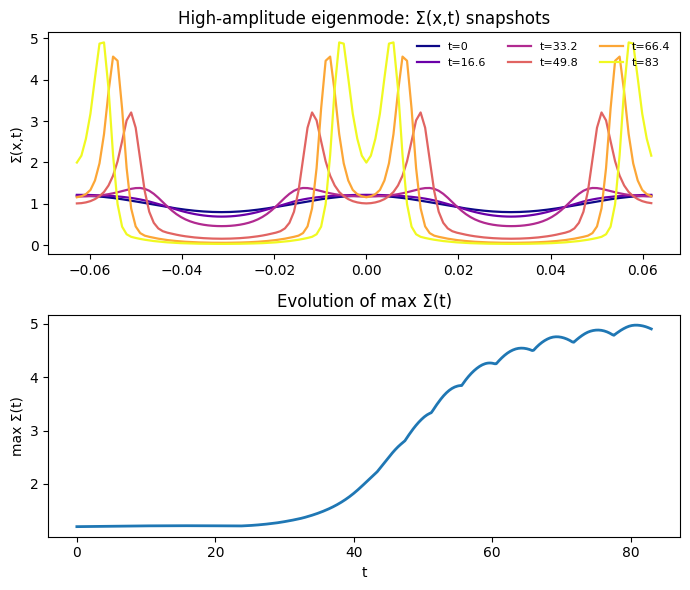

In [183]:
# %% Σ(x,t) snapshots and max Σ(t) vs time
nsamp = 6
idxs = np.linspace(0, len(T) - 1, nsamp, dtype=int)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=False)

# Top: Σ(x,t) snapshots with colormap by time
cmap = plt.get_cmap("plasma")
for j, i in enumerate(idxs):
    color = cmap(j / max(nsamp - 1, 1))
    ax1.plot(x, Sig[i], lw=1.6, color=color, label=f"t={T[i]:.3g}")
ax1.set_ylabel("Σ(x,t)")
ax1.set_title("High-amplitude eigenmode: Σ(x,t) snapshots")
ax1.legend(ncol=3, fontsize=8, frameon=False)

# Bottom: max Σ(t)
Sig_max = Sig.max(axis=1)
ax2.plot(T, Sig_max, lw=2)
ax2.set_xlabel("t")
ax2.set_ylabel("max Σ(t)")
ax2.set_title("Evolution of max Σ(t)")

plt.tight_layout()
plt.show()

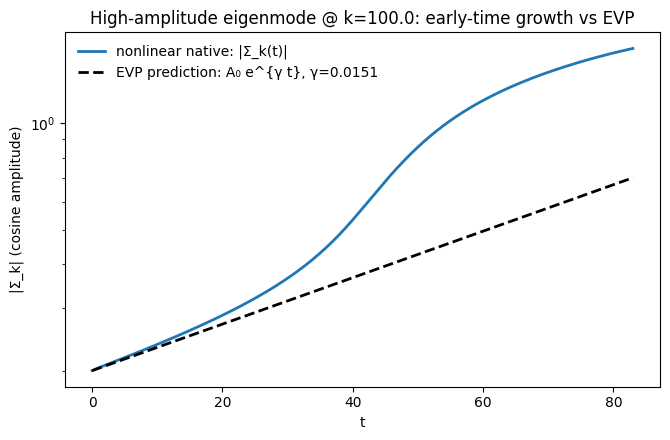

In [184]:
# %% Mode amplitude at k_phys vs EVP linear prediction
from diffinst.analysis_api import amplitude_at_k_from_sigma

# Find FFT index corresponding to k_phys in this box
k_idx = nearest_k_index(Lx, Nx, k_phys)

# Amplitude series (resolution-independent cosine amplitude)
T_amp, A = amplitude_series_from_sigma(T, Sig, k_idx)

# Linear growth rate from EVP using the same config as the run
cfg = Config.from_yaml(ROOT / "experiments" / "unstable_baseline.yaml",
                       ROOT / "defaults.yaml")
gamma = evp_gamma(cfg, k_phys)

# Build linear prediction from the initial amplitude
A0 = A[0]
A_lin = A0 * np.exp(gamma * (T_amp - T_amp[0]))

fig, ax = plt.subplots(figsize=(6.8, 4.5))
ax.plot(T_amp, A, lw=2, label="nonlinear native: |Σ_k(t)|")
ax.plot(T_amp, A_lin, "k--", lw=2, label=f"EVP prediction: A₀ e^{{γ t}}, γ={gamma:.3g}")

ax.set_yscale("log")
ax.set_xlabel("t")
ax.set_ylabel("|Σ_k| (cosine amplitude)")
ax.set_title(f"High-amplitude eigenmode @ k={k_phys}: early-time growth vs EVP")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

In [186]:
# %% Diagnostics from metrics: mass(t) and mode1_amp(t)
tM, cols = load_metrics(RUN_NL)

if tM.size == 0 or not cols:
    print("No metrics.jsonl found for this run.")
else:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 5), sharex=True)

    if "mass" in cols:
        ax1.plot(tM, cols["mass"], lw=2)
        ax1.set_ylabel("⟨Σ⟩")
        ax1.set_title("Mass conservation check")

    if "mode1_amp" in cols:
        ax2.plot(tM, cols["mode1_amp"], lw=2)
        ax2.set_ylabel("|Σ_{k=1}| (raw FFT)")
        ax2.set_xlabel("t")
        ax2.set_title("Low-k mode diagnostic (mode1_amp)")
        ax2.set_yscale('log')

    plt.tight_layout()
    plt.show()

OverflowError: cannot convert float infinity to integer

Error in callback <function _draw_all_if_interactive at 0x11a365260> (for post_execute), with arguments args (),kwargs {}:


OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

<Figure size 640x500 with 2 Axes>

Last finite checkpoint: chk_083000.npz  (t = 83)
Field extrema:
  Sigma: min=3.087416e-02, max=4.902606e+00
  vx:    min=-1.379217e-03,    max=1.379217e-03
  vy:    min=-2.211072e-03,    max=2.211072e-03
  uy:    min=-6.991334e-04,    max=6.991334e-04
Gradient extrema (central diff, periodic):
  dSigma/dx: min=-1.422047e+03, max=1.422047e+03
  dvx/dx:    min=-1.404859e+00,    max=1.127660e+00


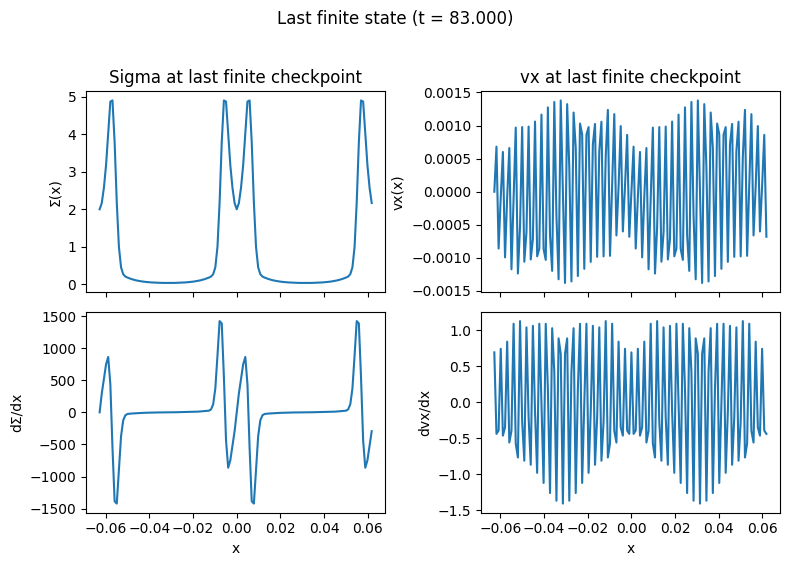

In [187]:
# %% Inspect last finite checkpoint of a nonlinear run
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from diffinst.analysis_api import list_checkpoints

# --- set your run directory here ---
RUN_DIR = Path("runs/nl_eigen_highamp_native")   # <-- adjust if needed

files = list_checkpoints(RUN_DIR)
if not files:
    raise FileNotFoundError(f"No checkpoints found in {RUN_DIR}")

last_finite_fn = None
last_finite_data = None

# Walk backwards through checkpoints and pick the last one with all-finite fields
for fn in reversed(files):
    Z = np.load(fn)
    Sigma = Z["Sigma"]
    vx    = Z["vx"]
    vy    = Z["vy"]
    uy    = Z["uy"]

    all_finite = (
        np.isfinite(Sigma).all()
        and np.isfinite(vx).all()
        and np.isfinite(vy).all()
        and np.isfinite(uy).all()
    )
    if all_finite:
        last_finite_fn = fn
        last_finite_data = Z
        break

if last_finite_fn is None:
    raise RuntimeError("No finite checkpoint found — run blew up immediately?")

# Unpack
t_last = float(last_finite_data["t"])
x      = last_finite_data["x"]
Sigma  = last_finite_data["Sigma"]
vx     = last_finite_data["vx"]
vy     = last_finite_data["vy"]
uy     = last_finite_data["uy"]

# Periodic finite-difference for gradients
dx = float(x[1] - x[0])
dSigma_dx = (np.roll(Sigma, -1) - np.roll(Sigma, 1)) / (2.0 * dx)
dvx_dx    = (np.roll(vx,    -1) - np.roll(vx,    1)) / (2.0 * dx)

print(f"Last finite checkpoint: {last_finite_fn.name}  (t = {t_last:.6g})")
print("Field extrema:")
print(f"  Sigma: min={Sigma.min():.6e}, max={Sigma.max():.6e}")
print(f"  vx:    min={vx.min():.6e},    max={vx.max():.6e}")
print(f"  vy:    min={vy.min():.6e},    max={vy.max():.6e}")
print(f"  uy:    min={uy.min():.6e},    max={uy.max():.6e}")
print("Gradient extrema (central diff, periodic):")
print(f"  dSigma/dx: min={dSigma_dx.min():.6e}, max={dSigma_dx.max():.6e}")
print(f"  dvx/dx:    min={dvx_dx.min():.6e},    max={dvx_dx.max():.6e}")

# --- quick snapshot plots ---
fig, axes = plt.subplots(2, 2, figsize=(8, 5.5), sharex=True)

axes[0, 0].plot(x, Sigma)
axes[0, 0].set_ylabel("Σ(x)")
axes[0, 0].set_title("Sigma at last finite checkpoint")

axes[0, 1].plot(x, vx)
axes[0, 1].set_ylabel("vx(x)")
axes[0, 1].set_title("vx at last finite checkpoint")

axes[1, 0].plot(x, dSigma_dx)
axes[1, 0].set_ylabel("dΣ/dx")
axes[1, 0].set_xlabel("x")

axes[1, 1].plot(x, dvx_dx)
axes[1, 1].set_ylabel("dvx/dx")
axes[1, 1].set_xlabel("x")

fig.suptitle(f"Last finite state (t = {t_last:.3f})", y=1.02)
plt.tight_layout()
plt.show()